In [1]:
import numpy as np
import os
import lsst.afw.image as afwImage
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
from mpl_toolkits.axes_grid1 import ImageGrid


%matplotlib inline

def plot(arr, title, cmap=None, vmin=None, vmax=None):
    plt.figure(figsize=(11,10))
    if vmin is None:
        vmin = np.percentile(arr[np.where(np.isfinite(arr))], 2)
    if vmax is None:
        vmax = np.percentile(arr[np.where(np.isfinite(arr))], 98)
    plt.imshow(arr, vmin=vmin, vmax=vmax,  origin='lower', cmap=cmap, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.show()

# Coadd Artifact Rejection Discussion





## Goal:

### Generate *clean* coadds for *detection*.

## by removing temporal junk. 

What kinds?

* *Imaged*: Asteroids -- Ghosts --  Glints -- Satellites
* *Non-Imaged*: Cosmic rays -- Reprojection edges -- Chip defects
 
 ![Examples](9examples.png "Examples")



%%HTML
<video controls>                                                                
    <source                                                                     
        src="76-movie2.m4v"
        type="video/mp4">                                                       
</video>


[![Test Video]()](https://www.dropbox.com/s/ot36i0oahxw2r2f/76-movie2.m4v)

# Why now?

## Some project history

* S12 -> sigma clipped coadds
* S15 -> safe clipped coadds

![alt text](s13.jpg "SigmaClipped")

* S12 -> sigma clipped coadds
* S15 -> safe clipped coadds

example 4 from Bob's ticket:
https://hsc-jira.astro.princeton.edu/jira/browse/HSC-1166:

# Safe Clipped ..........................  Mean ............................. Sigma Clipped
![alt text](example4.png "SigmaClipped")

In [2]:
from collections import OrderedDict
DATA_DIR = '/tigress/HSC/HSC/rerun/alsayyad/'
butlerMean = dafPersist.Butler(os.path.join(DATA_DIR, 'cosmos_test_artifact_reject_mean'))
butlerSigmaClip = dafPersist.Butler(os.path.join(DATA_DIR, 'cosmos_test_artifact_reject_sigmaclip'))
butlerSafeClip = dafPersist.Butler(os.path.join(DATA_DIR, 'cosmos_test_artifact_reject_safeClip'))

coaddDict = OrderedDict()
coaddDict['SafeClip']= butlerSafeClip.get('deepCoadd', tract=0, patch='7,6', filter='HSC-I')
coaddDict['Mean'] = butlerMean.get('deepCoadd', tract=0, patch='7,6', filter='HSC-I')
coaddDict['SigmaClip'] = butlerSigmaClip.get('deepCoadd', tract=0, patch='7,6', filter='HSC-I')

In [3]:
from scipy.ndimage.filters import gaussian_filter
def plot76Slice(coaddDict, idx, doFilter=False):
    fig = plt.figure(1, (12., 6.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(1, 3), 
                     axes_pad=0.0,
                     label_mode='1', 
                     cbar_mode = 'single',
                     cbar_location="bottom"
                     )
    for i, (coaddType, exp) in enumerate(coaddDict.iteritems()):
        arr = exp.maskedImage.image.array[slice(idx[0], idx[1]), slice(idx[2], idx[3])]
        arr = gaussian_filter(arr, 2) if doFilter else arr
        factor = 4. if doFilter else 1.
        im = grid[i].imshow(arr,
               vmin=-0.06/factor, vmax=0.16/factor, cmap='Greys_r', origin='lower',interpolation='nearest')
        grid[i].text(5,5, coaddType, color='white', size=20)

    grid.cbar_axes[0].colorbar(im)
    plt.show()

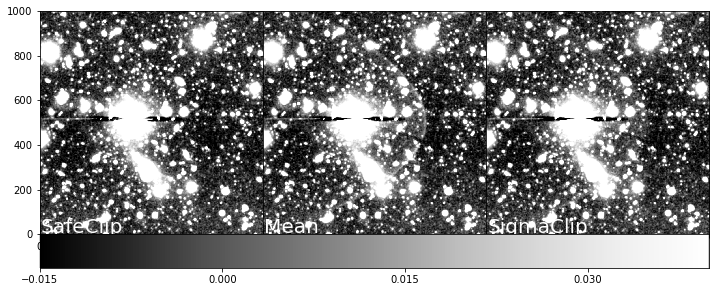

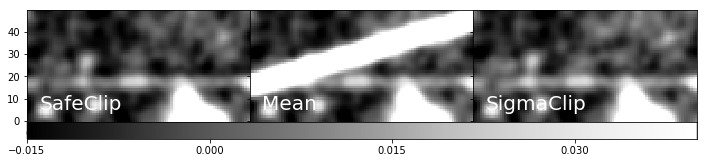

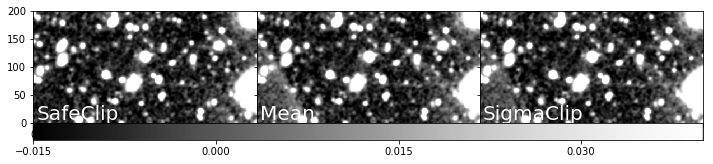

In [4]:
plot76Slice(coaddDict, idx=[2000,3000, 1000, 2000], doFilter=True)
plot76Slice(coaddDict, idx=[850, 900,300,400], doFilter=True) #satellites
plot76Slice(coaddDict, idx=[0, 200, 0, 400], doFilter=True) #ghosts


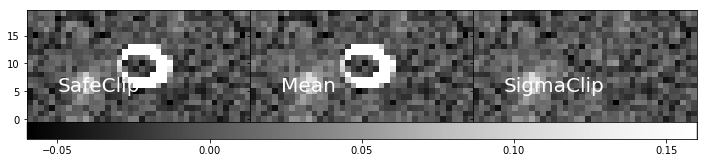

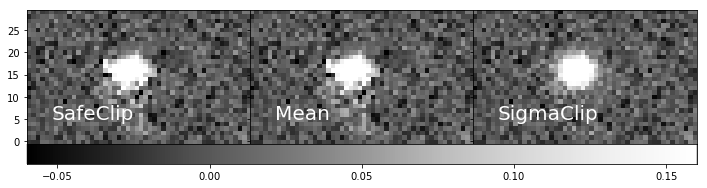

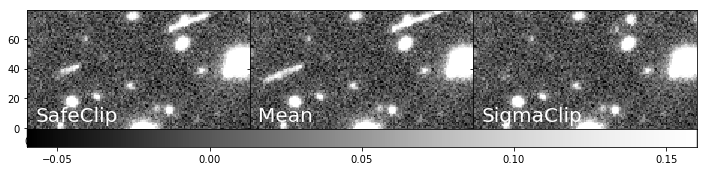

In [5]:
pix = 20
plot76Slice(coaddDict, idx=[2950-pix//2, 2950+pix//2, 1288-pix, 1288+pix])
plot76Slice(coaddDict, idx=[1990, 2020, 2000,2050])
plot76Slice(coaddDict, idx=[2300, 2380, 700, 850])

In [6]:
expDict = {}

DIR = "/tigress/HSC/HSC/rerun/alsayyad/warp_compare/MEDIAN"
for filename in sorted(os.listdir(DIR)):
    visit = filename.replace('.fits', '')
    try:
        visitNum = int(visit)
    except Exception as e:
        print "Skipping %s" % (visit)
        continue
    expDict[visit] = afwImage.ExposureF(os.path.join(DIR, filename))

imList = []
keyList = []
varList = []
for key, exp in expDict.iteritems():
    keyList.append(key)
    imList.append(exp.getMaskedImage().getImage().getArray())
    varList.append(exp.getMaskedImage().getVariance().getArray())
    
medianCoadd = afwImage.ExposureF(os.path.join(DIR, 'psfMatched-7,6.fits'))
cube = np.array(imList)
cubeVar = np.array(varList)
cubeSNR = cube/np.sqrt(cubeVar)

Skipping psfMatched-7,6


## Now with proper PSF-matching we can subtract individual epochs

In [7]:
def plotCube(arr, keyList, vmin=None, vmax=None, cmap=None, title=None):
    N = len(arr)
    fig = plt.figure(1, (12., 8.))
    fig.suptitle(title)
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(5, 7),
                     axes_pad=0.1, 
                     )
    if vmin is None:
        vmin = np.percentile(arr[np.where(np.isfinite(arr))], 5)
    if vmax is None:
        vmax = np.percentile(arr[np.where(np.isfinite(arr))], 95)
    for i in range(N):
        grid[i].text(100, 3500, keyList[i])
        grid[i].imshow(arr[i], vmin=vmin, vmax=vmax, origin='lower', cmap=cmap)
    plt.show()

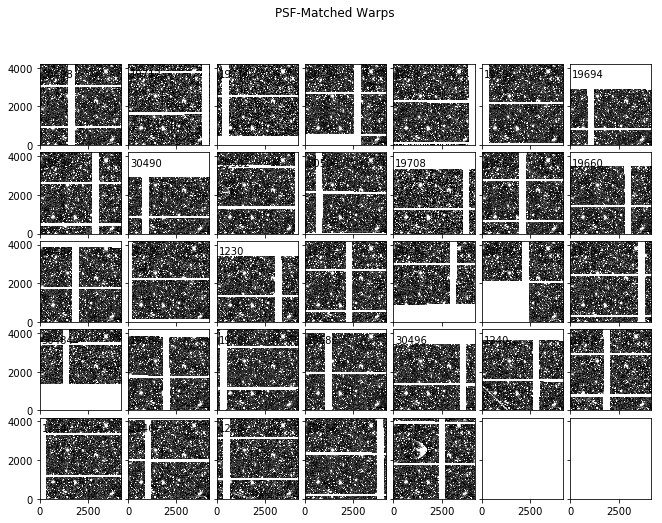

In [8]:
plotCube(cube + medianCoadd.maskedImage.image.array, keyList, cmap='Greys_r', title="PSF-Matched Warps")

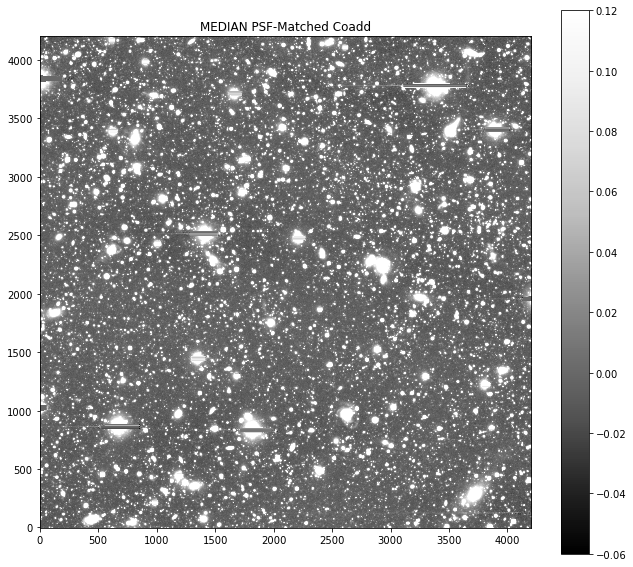

In [9]:
plot(medianCoadd.maskedImage.image.array, 'MEDIAN PSF-Matched Coadd', cmap='Greys_r', vmin=-0.06, vmax=0.12)

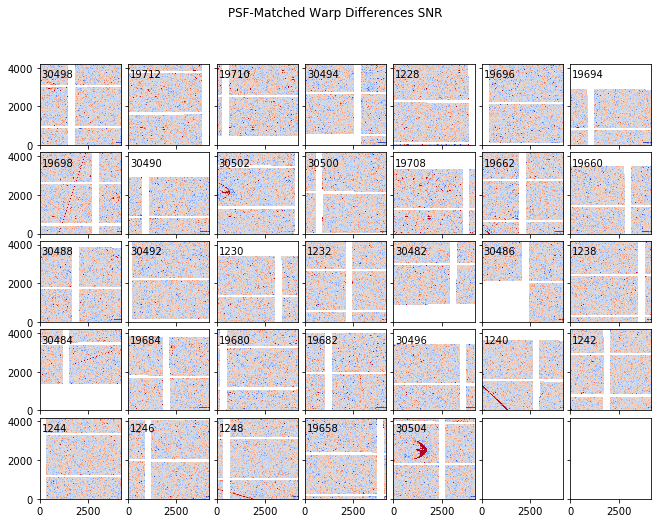

In [10]:
# PSF-Matched Warp Differences
# Subtract off the median
# Divide by sqrt(var)

plotCube(cubeSNR, keyList, vmin=-5, vmax=5,  cmap='coolwarm', title='PSF-Matched Warp Differences SNR')

In [11]:
def plotImperfections(cube, cubeSNR, keyList, idx, title):
    N = len(cube)
    plt.imshow(cube[keyList.index('30504')][slice(idx[0], idx[1]), slice(idx[2], idx[3])],vmin=-0.07, vmax=0.07, 
               origin='lower', cmap="magma_r", interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.show()

    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(6, 6), 
                     axes_pad=0.1,
                     label_mode='1', 
                     cbar_mode = 'single',
                     cbar_location="bottom"
                     )

    for i in range(N):
        grid[i].text(10,10, keyList[i])
        im = grid[i].imshow(cubeSNR[i,slice(idx[0], idx[1]), slice(idx[2], idx[3])], vmin=-5, vmax=5,
                            origin='lower', cmap='coolwarm')

    grid.cbar_axes[0].colorbar(im)

## What are in these Difference SNR maps?

## 1. Real transients we want to mask

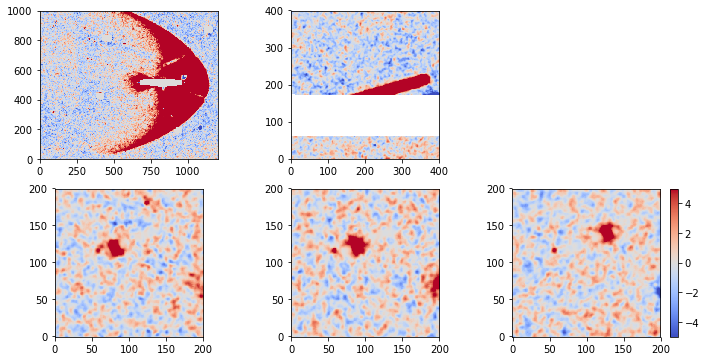

In [12]:
# 1. Real transients and artifacts
fig = plt.figure(1, (12., 6.))
commonArgs = dict(vmin=-5, vmax=5, cmap='coolwarm', origin='lower', interpolation='nearest')
plt.subplot(231); plt.imshow(cubeSNR[keyList.index('30504')][2000:3000, 600:1800], **commonArgs)
plt.subplot(232); plt.imshow(cubeSNR[keyList.index('19694')][700:1100,100:500], **commonArgs)
plt.subplot(234); plt.imshow(cubeSNR[keyList.index('1230')][2300:2500, 400:600], **commonArgs)
plt.subplot(235); plt.imshow(cubeSNR[keyList.index('1232')][2300:2500, 400:600], **commonArgs)
plt.subplot(236); plt.imshow(cubeSNR[keyList.index('1244')][2300:2500, 400:600], **commonArgs)
plt.colorbar()

## What are in these Difference SNR maps?
## 1. Real transients we want to mask
## 2. ...And subtraction imperfections

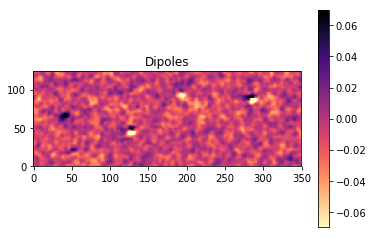

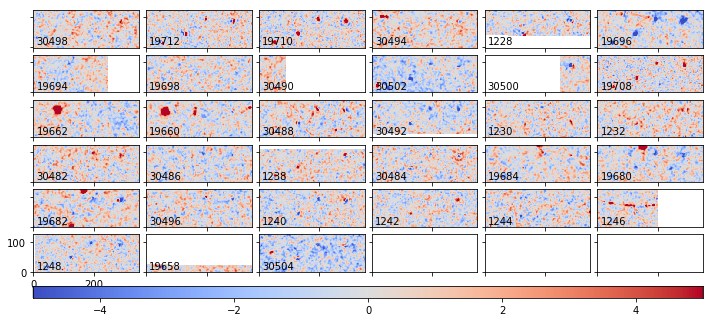

In [13]:
# a. Dipoles
plotImperfections(cube, cubeSNR, keyList, idx=[2250,2375, 650,1000] , title='Dipoles')

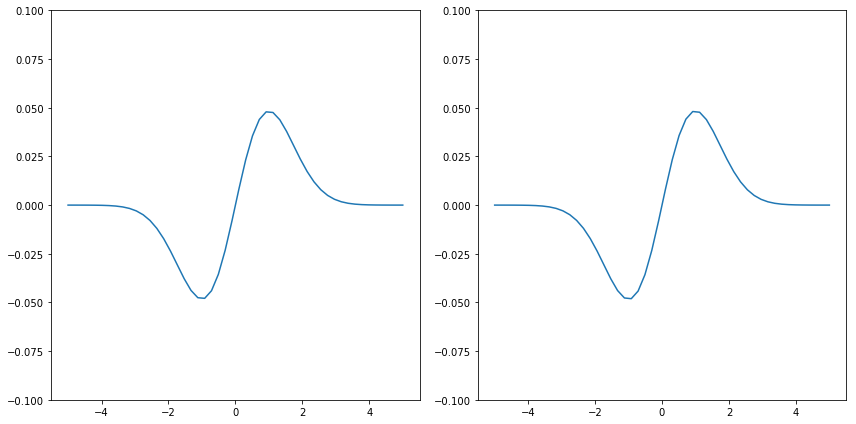

In [34]:
# Recall that if astrometric error << PSF width
# dipoles depend more on flux than astrometric offset. 

from scipy.stats import norm
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
OFFSET = 0.1
FLUX = 1.

x = np.linspace(-5, 5)
y1 = FLUX * norm.pdf(x, OFFSET, 1)
y2 = FLUX * norm.pdf(x, -OFFSET, 1)
plt.plot(x, y1-y2)
plt.ylim(-0.1, +0.1)
plt.subplot(122)

OFFSET = 0.0001
FLUX = 1000.
x = np.linspace(-5, 5)
y1 = FLUX * norm.pdf(x, OFFSET, 1)
y2 = FLUX * norm.pdf(x, -OFFSET, 1)
plt.plot(x, y1-y2)
plt.ylim(-0.1, +0.1)
plt.tight_layout()

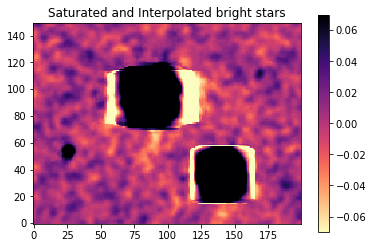

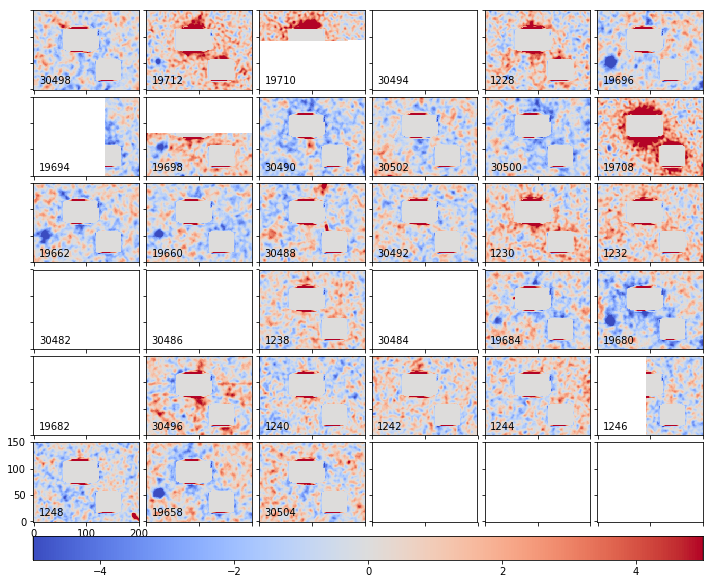

In [15]:
# b. Saturated and Interpolated Stars
plotImperfections(cube, cubeSNR, keyList, idx=[350, 500, 1100, 1300], title='Saturated and Interpolated bright stars')

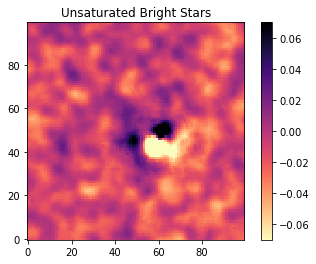

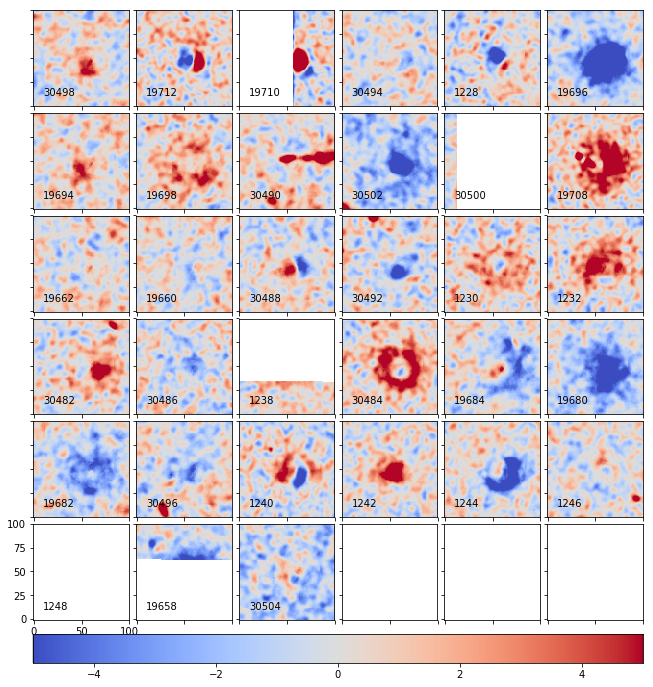

In [16]:
# Unsaturated Bright Stars
plotImperfections(cube, cubeSNR, keyList, idx=[2325, 2425, 550, 650], title="Unsaturated Bright Stars")

## Goal: Separate the real transients (we want to mask) from the subtraction junk.

* Option 1: We know where the bright stars are
* Option 2: If an object is hard to subtract in one epoch, then it is hard to subtract in many. 

In [17]:
# Convert the stack of SNR Maps into binary map
# True if < -5 or > 5  (for testing hypothesis that pixel has 5 sigma difference from median)

#snr = np.copy(cubeSNR)
#snr[np.where((snr < 5) & (snr > -5))] = 0
count = np.copy(cubeSNR)
count[np.where(np.isnan(cubeSNR))] = 0
count[np.where((cubeSNR < 5) & (cubeSNR > -5))] = 0
count[np.where((cubeSNR > 5) | (cubeSNR < -5))] = 1
sum_count = np.nansum(count, axis=0)

N = len(count)
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


/tigress/HSC/LSST/stack_tiger_20170721/python/miniconda2-4.2.12/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/tigress/HSC/LSST/stack_tiger_20170721/python/miniconda2-4.2.12/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/tigress/HSC/LSST/stack_tiger_20170721/python/miniconda2-4.2.12/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/tigress/HSC/LSST/stack_tiger_20170721/python/miniconda2-4.2.12/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


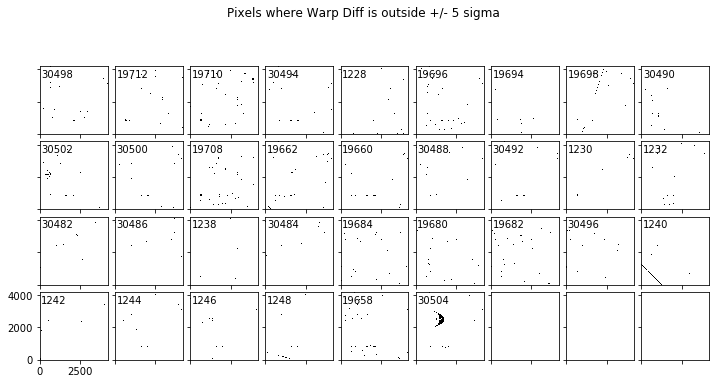

In [18]:
fig = plt.figure(1, (12., 6.))
fig.suptitle("Pixels where Warp Diff is outside +/- 5 sigma")
grid = ImageGrid(fig, 111, nrows_ncols=(4, 9), axes_pad=0.1, label_mode='1')
for i in range(N):
    grid[i].text(100,3500, keyList[i])
    grid[i].imshow(count[i],  origin='lower', cmap='Greys')
plt.show()

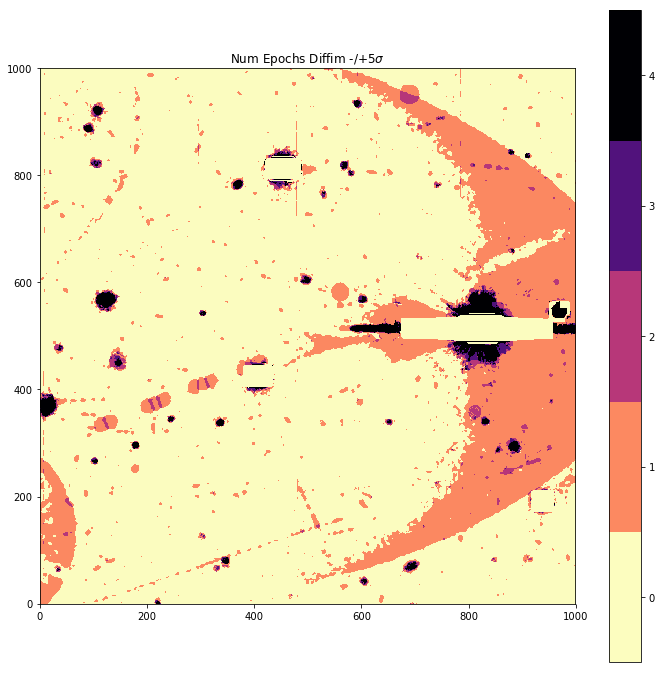

In [19]:
import matplotlib
cmap=plt.cm.magma_r
plt.figure(figsize=(12,12))
commonArgs = dict(origin='lower', cmap=plt.cm.magma_r, interpolation='nearest',
                  norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N))
plt.title("Num Epochs Diffim -/+5$\sigma$")
plt.imshow(sum_count[2000:3000, 600:1600],**commonArgs)
plt.colorbar(ticks=np.arange(0,6,1))

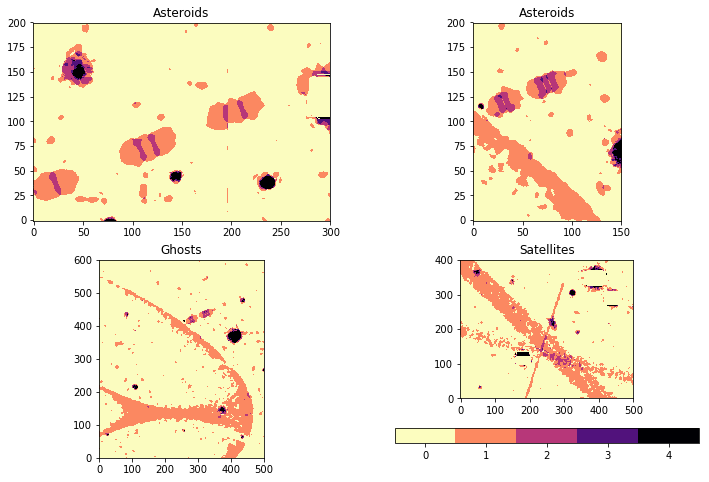

In [20]:
plt.figure(figsize=(12,8))
plt.subplot(221); plt.imshow(sum_count[2300:2500, 700:1000], **commonArgs); plt.title("Asteroids")
plt.subplot(222); plt.imshow(sum_count[2300:2500, 450:600], **commonArgs); plt.title("Asteroids")
plt.subplot(223); plt.imshow(sum_count[2000:2600, 200:700], **commonArgs); plt.title("Ghosts")
plt.subplot(224); plt.imshow(sum_count[100:500, 800:1300], **commonArgs); plt.title("Satellites")
plt.colorbar(orientation='horizontal', ticks=np.arange(0,6,1))

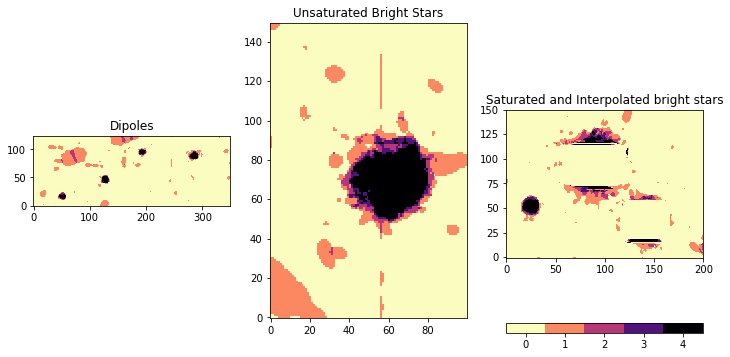

In [21]:
plt.figure(figsize=(12,8))
plt.subplot(131); plt.imshow(sum_count[2250:2375, 650:1000], **commonArgs); plt.title("Dipoles")
plt.subplot(132); plt.imshow(sum_count[2300:2450, 550:650], **commonArgs); plt.title("Unsaturated Bright Stars")
plt.subplot(133); plt.imshow(sum_count[350:500, 1100:1300], **commonArgs); plt.title("Saturated and Interpolated bright stars")
plt.colorbar(orientation='horizontal', ticks=np.arange(0,6,1))

## With "count map" in hand.  Loop over each Warp Diff SNR map
* Threshold on SNR map rather than use `SourceDetectionTask` because not all artifacts are imaged. We are NOT looking for PSFs!
* For all footprints that are more than 50% 1-2 epoch only. Mask it. Else: don't mask it.


* Lets look at visit "30504" as an example:


In [22]:
import numpy
def _snrToBinary(arrIn, threshold=5, clipNeg=False):
    arr = numpy.copy(arrIn)
    arr[numpy.where(arrIn < threshold)] = 0
    arr[numpy.where(arrIn >= threshold)] = 1
    if clipNeg:
        arr[numpy.where(arrIn <= -threshold)] = 1
    return arr

visit = 30504
exp = expDict['30504']
im = exp.getMaskedImage().getImage()
mask = exp.getMaskedImage().getMask()
mask.addMaskPlane("CLIPPED")
var = exp.getMaskedImage().getVariance()

snrIm = im.Factory(1./np.sqrt(var.getArray()))
snrIm *= exp.getMaskedImage().getImage()
snrArr = _snrToBinary(snrIm.array, threshold=5, clipNeg=True)

#noDataValue = mask.addMaskPlane("NO_DATA")
#nans = numpy.zeros_like(snrArr, dtype=afwImage.MaskPixel)
#nans[numpy.where(numpy.isnan(snrArr))] = 2**noDataValue
#nansMask = afwImage.makeMaskFromArray(nans.astype(afwImage.MaskPixel))

snrArr[numpy.where(numpy.isnan(snrArr))] = 0
outliers = afwImage.makeMaskFromArray(snrArr.astype(afwImage.MaskPixel))
newSpans = afwGeom.SpanSet.fromMask(outliers)
splitSpans = newSpans.split()

maskedSpans = []
unmaskedSpans = []
percentList = []
for i, span in enumerate(splitSpans):
    x, y = span.indices()
    counts = sum_count[x, y]
    percentOneEpoch = float(len(counts[numpy.where((counts == 1) | (counts == 2)) ]))/float(len(counts))
    if percentOneEpoch > 0.50:
        maskedSpans.append(span)
    else:
        unmaskedSpans.append(span)
#biggerClipSpans = [s.dilated(5, afwGeom.Stencil.BOX) for s in clipSpans]   

/tigress/HSC/LSST/stack_tiger_20170721/python/miniconda2-4.2.12/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/tigress/HSC/LSST/stack_tiger_20170721/python/miniconda2-4.2.12/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/tigress/HSC/LSST/stack_tiger_20170721/python/miniconda2-4.2.12/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


In [23]:
maskedSpansSorted = [x for (y, x) in sorted(zip([len(span.indices()[0]) for span in maskedSpans], maskedSpans), reverse=True)]
unMaskedSpansSorted = [x for (y, x) in sorted(zip([len(span.indices()[0]) for span in unmaskedSpans], unmaskedSpans), reverse=True)]

In [24]:
def plotSpan(span, im, snrIm, compareIm, sum_count_pos):
    countIm = im.Factory(sum_count_pos)
    bigSpan = span.dilated(5, afwGeom.Stencil.CIRCLE)
    bigbigSpan = span.dilated(20, afwGeom.Stencil.CIRCLE) # For Plotting
    wholeBBox = im.getBBox()
    bigSpan = bigSpan.clippedTo(afwGeom.Box2I(afwGeom.Point2I(0,0,), im.getDimensions()))
    bigbigSpan = bigbigSpan.clippedTo(afwGeom.Box2I(afwGeom.Point2I(0,0,), im.getDimensions())) 
    subRegionBox = bigbigSpan.getBBox()
    snrWarp = snrIm.Factory(snrIm, subRegionBox)
    subRegionBox.shift(afwGeom.Extent2I(im.getX0(), im.getY0()))
    slateWarp = im.Factory(im, subRegionBox)
    compareIm = compareIm.Factory(compareIm, subRegionBox)
    slateCount = im.Factory(wholeBBox.getDimensions())
    span.copyImage(countIm, slateCount)
    slateCount = slateCount.Factory(slateCount, bigbigSpan.getBBox())
    slate = im.Factory(im.getBBox().getDimensions(), np.nan)
    bigSpan.setImage(slate, 1)
    slate *= im
    slate = slate.Factory(slate, bigbigSpan.getBBox())
    masked_data = slate.array
    masked_data = np.ma.masked_where(np.isnan(masked_data), masked_data)
    x, y = span.indices()
    counts = sum_count_pos[x, y]
    percentOneEpoch = float(len(counts[np.where(counts == 1)]))/float(len(counts))
    fig = plt.figure(1, (12., 6.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4), 
                 axes_pad=0.0,
                 label_mode='1', 
                 cbar_mode = 'None',
                 )
    norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5,5.5,1), cmap.N)
    grid[0].imshow(slateCount.array, vmin=0, vmax=5, cmap=cmap, norm=norm, origin='lower',interpolation='nearest')
    status = 'MASKED' if percentOneEpoch > 0.4 else 'NOT masked'
    grid[0].set_title("%d%% 1 or 2 epochs: %s" %(percentOneEpoch*100, status))

    grid[1].imshow(snrWarp.array, vmin=-5, vmax=5, origin='lower',interpolation='nearest')
    grid[1].set_title("Warp Diff SNR")
    grid[2].imshow(slateWarp.array, cmap='Greys_r', vmin=-0.06, vmax=0.12)
    grid[2].set_title("Warp Diff")
    grid[2].imshow(masked_data, cmap='Reds_r', interpolation='none', vmin=-0.06, vmax=0.12)

    grid[3].imshow(compareIm.array, vmin=-0.06, vmax=0.12, cmap='Greys_r',origin='lower',
                   interpolation='nearest')
    grid[3].set_title("Median Coadd")
    plt.show()



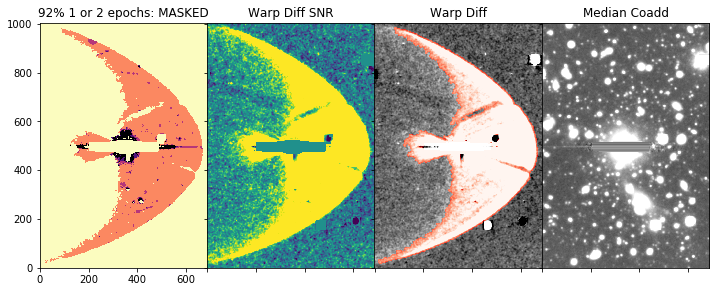

In [25]:
plotSpan(maskedSpansSorted[0], im, snrIm, medianCoadd.maskedImage.image, sum_count)

### Footprints masked:

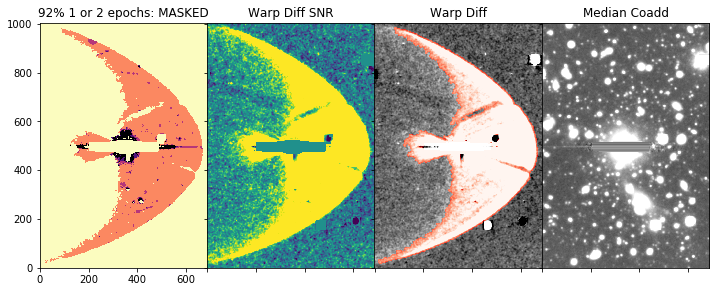

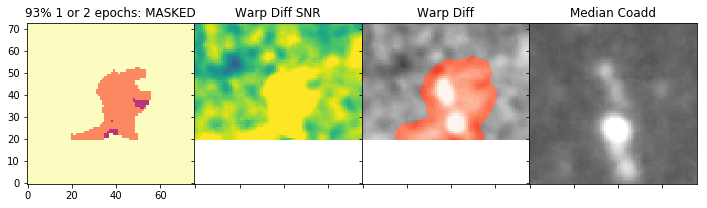

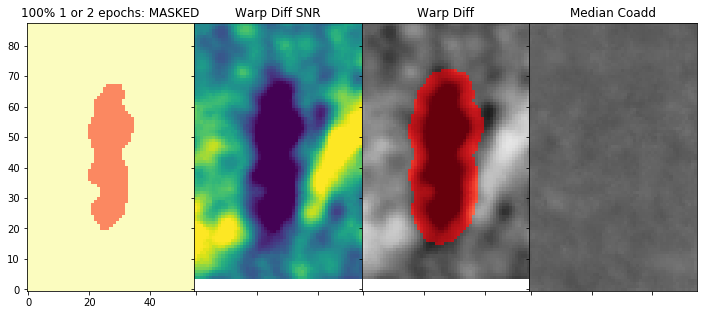

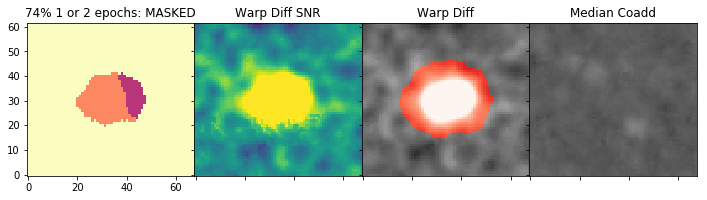

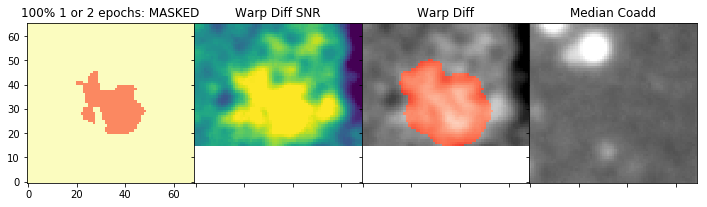

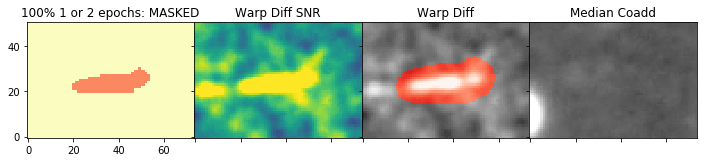

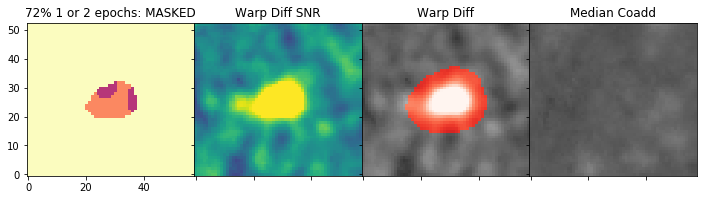

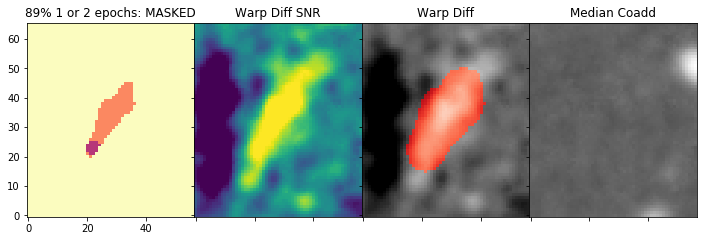

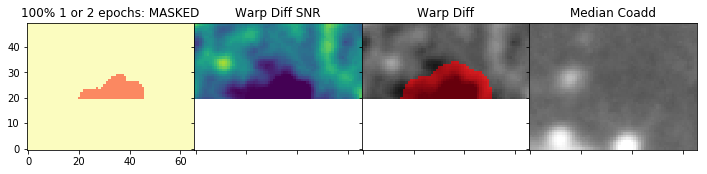

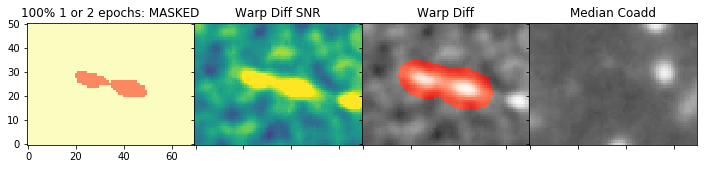

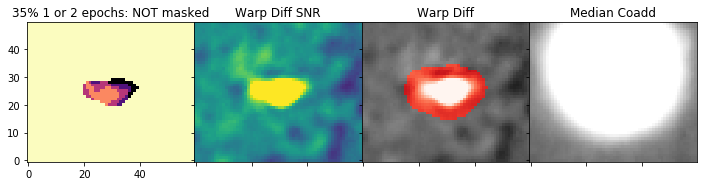

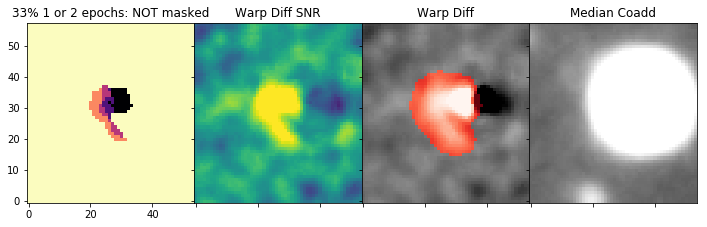

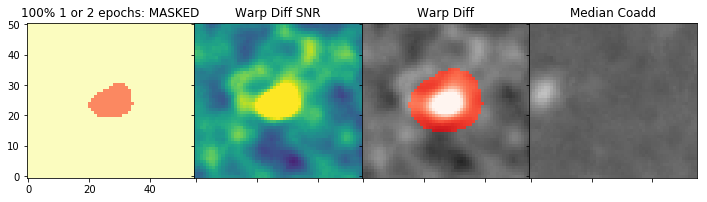

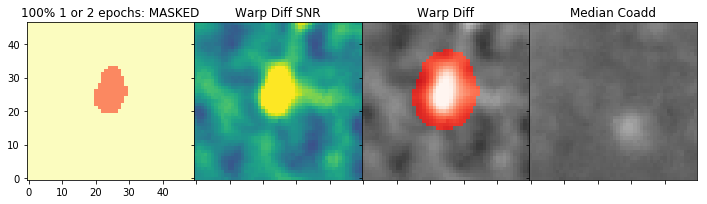

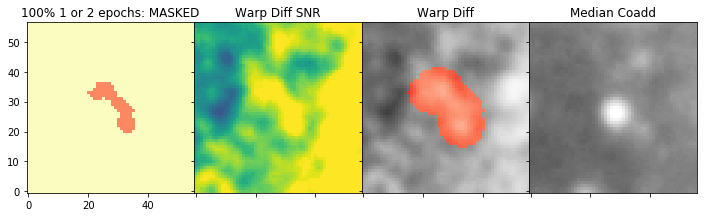

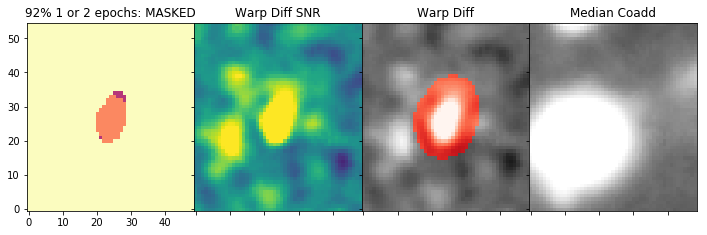

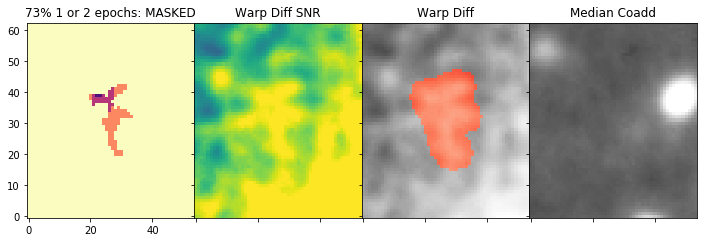

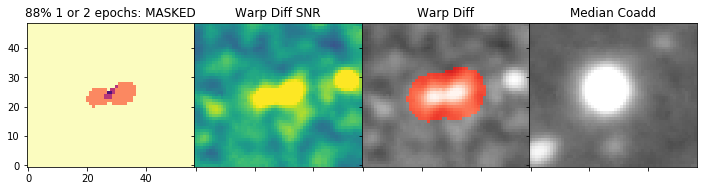

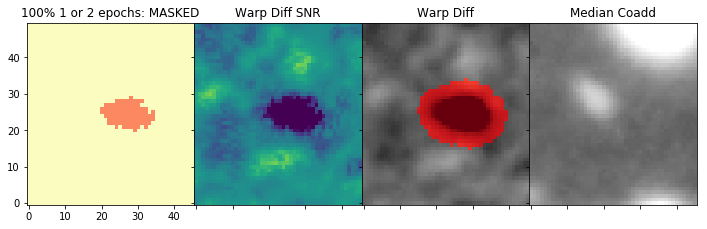

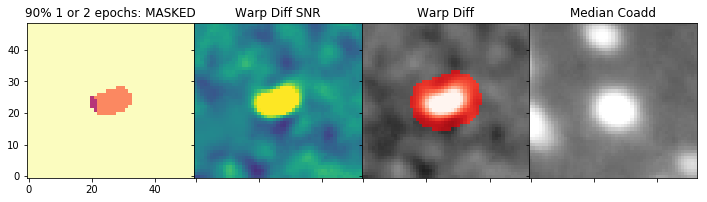

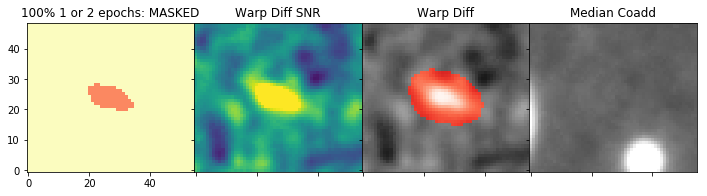

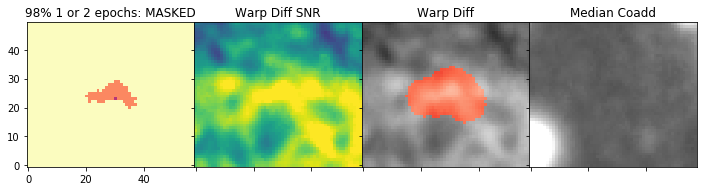

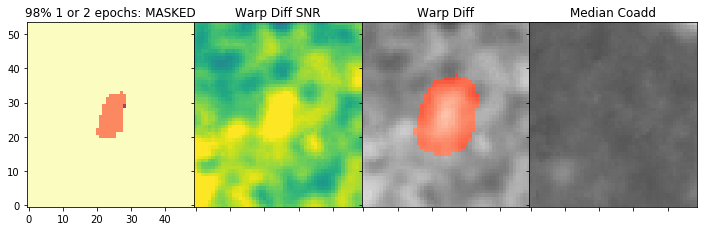

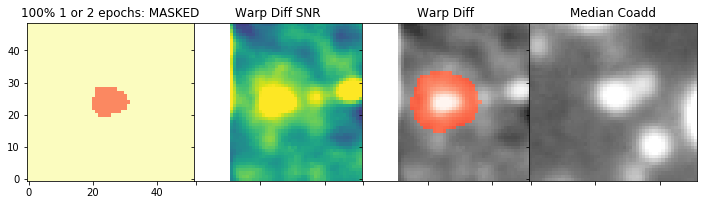

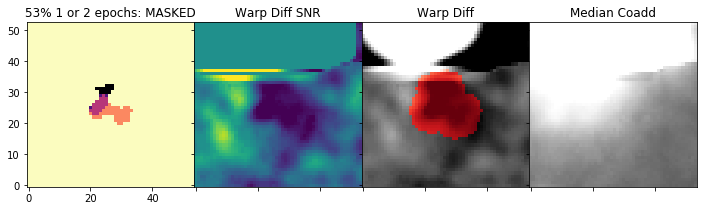

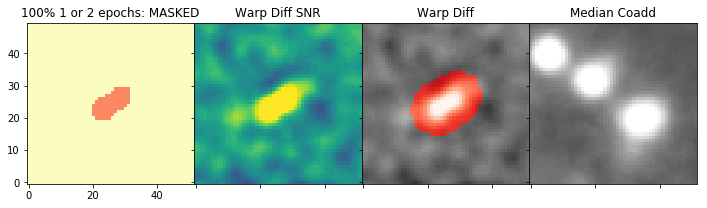

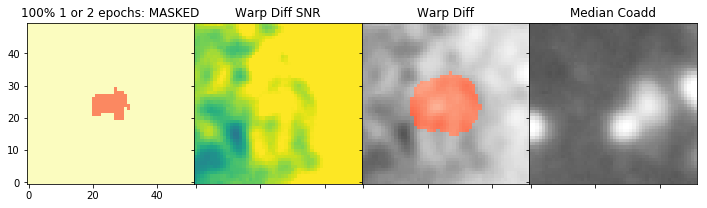

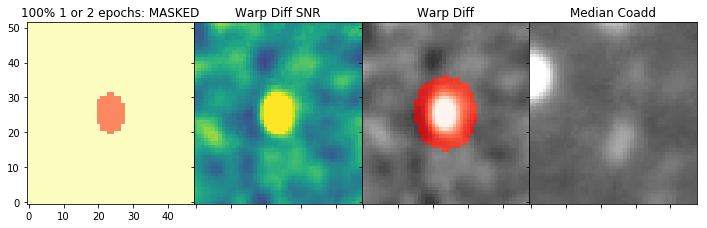

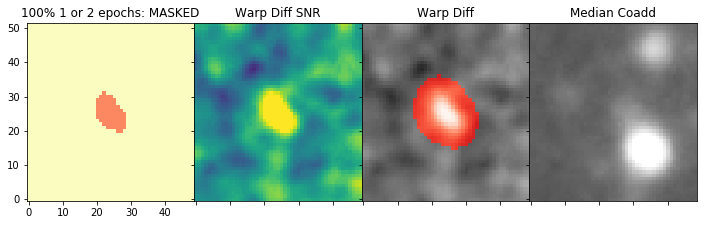

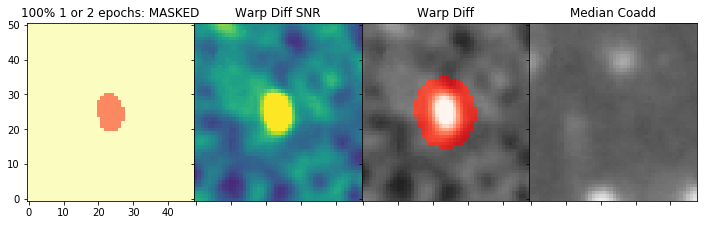

In [26]:
for span in maskedSpansSorted[0:30]:
    plotSpan(span, im, snrIm,medianCoadd.maskedImage.image,  sum_count)

### Footprints UNmasked

In [27]:
#for span in unMaskedSpansSorted[0:10]:
#    plotSpan(span, im, snrIm,medianCoadd.maskedImage.image,  sum_count)

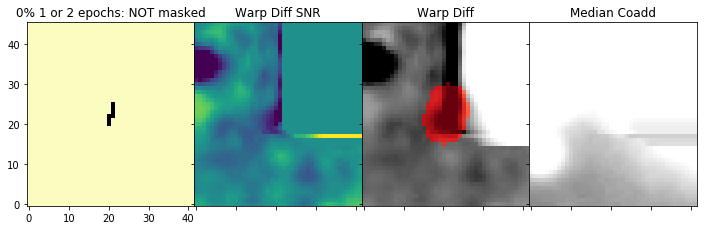

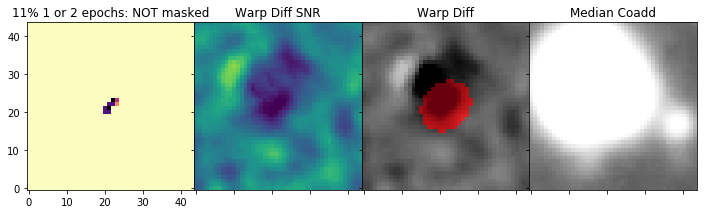

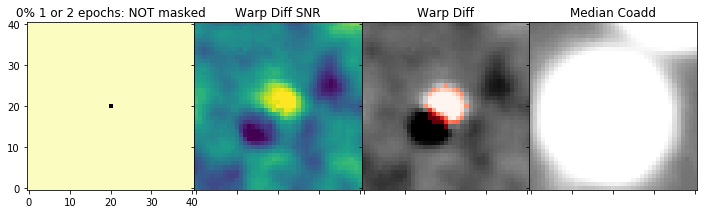

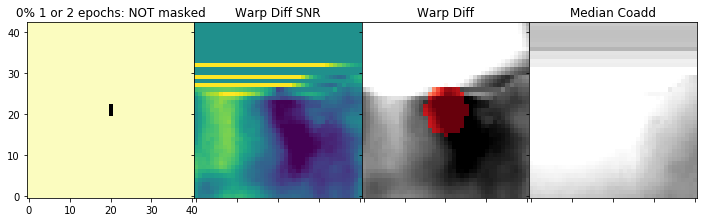

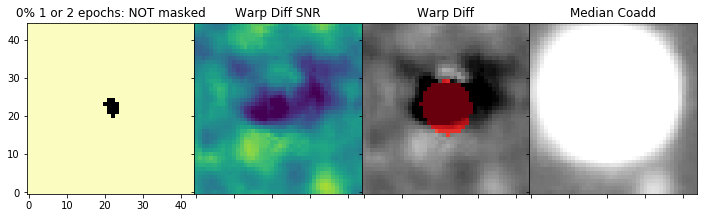

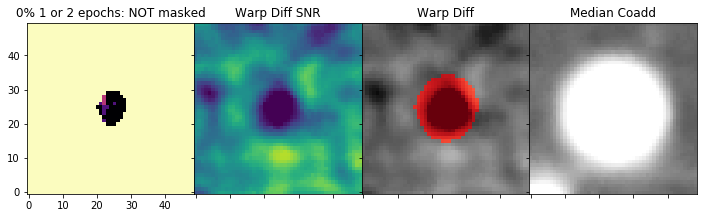

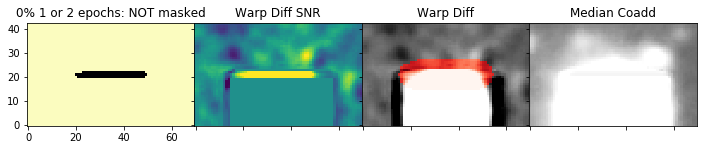

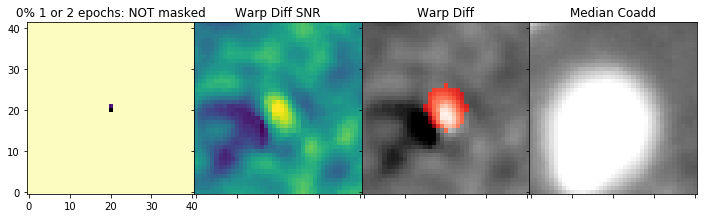

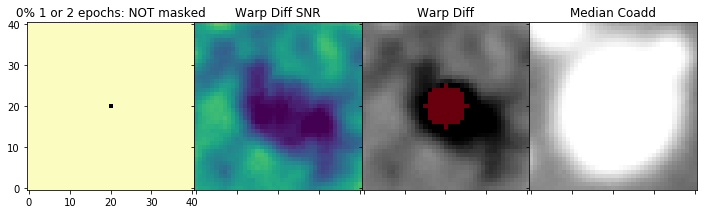

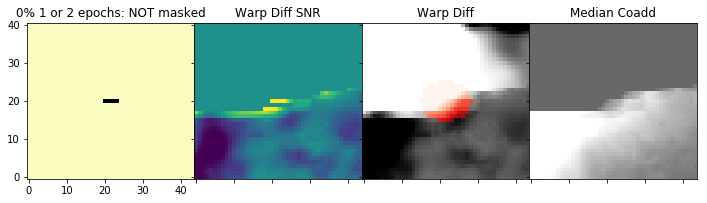

In [28]:
random10 = numpy.random.choice(np.arange(len(unmaskedSpans)), size=10)
for i in random10:
    plotSpan(unmaskedSpans[i], im, snrIm,medianCoadd.maskedImage.image,  sum_count)
                               

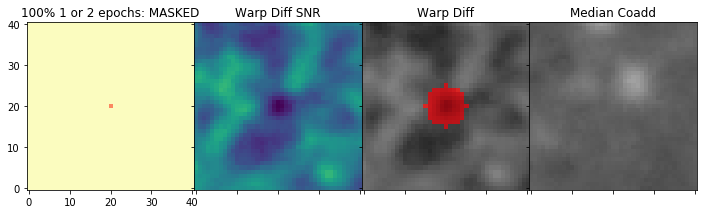

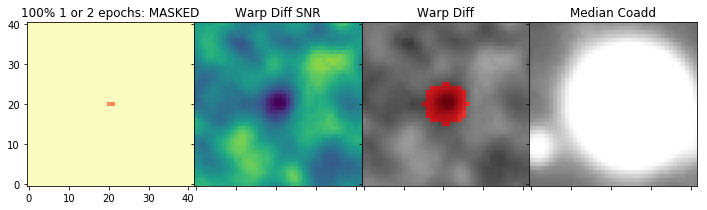

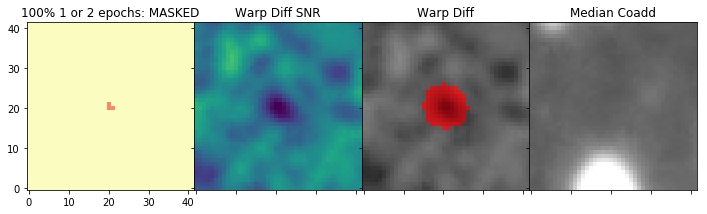

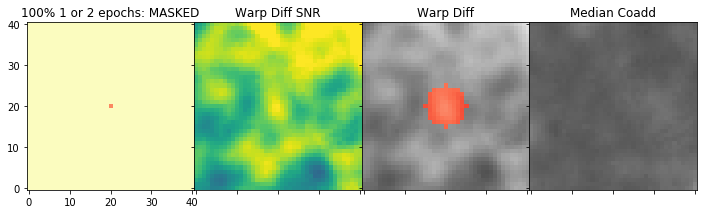

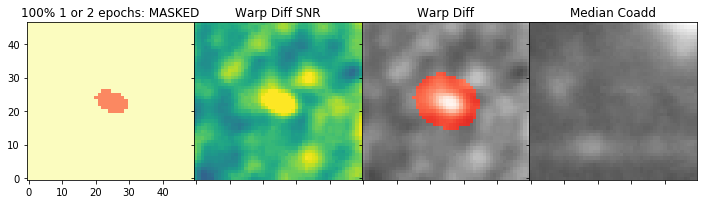

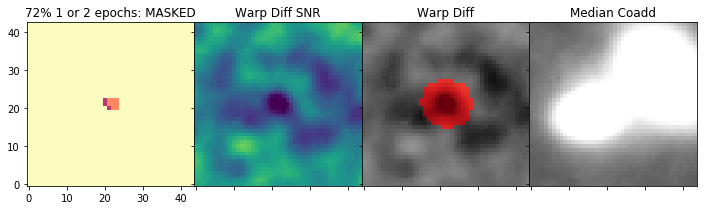

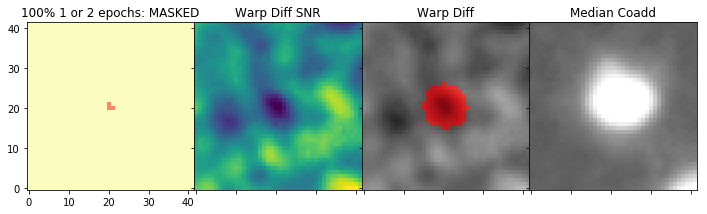

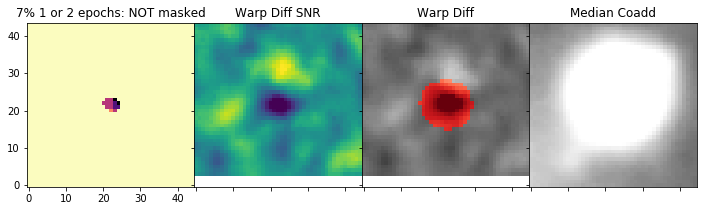

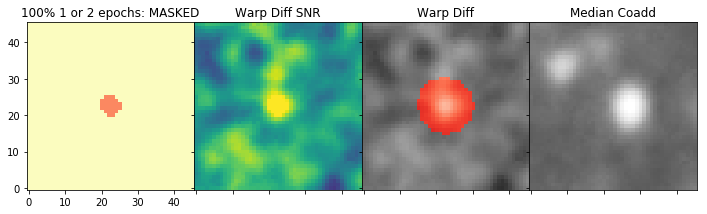

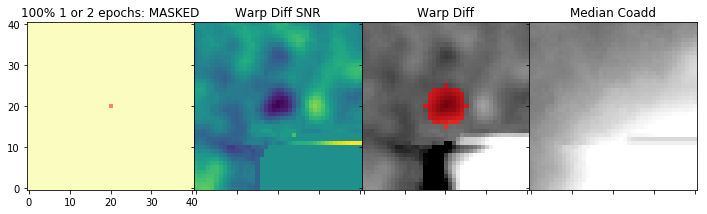

In [29]:
for i in random10:
    plotSpan(maskedSpans[i], im, snrIm,medianCoadd.maskedImage.image,  sum_count)
                               

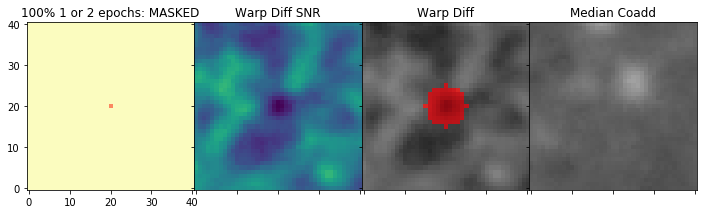

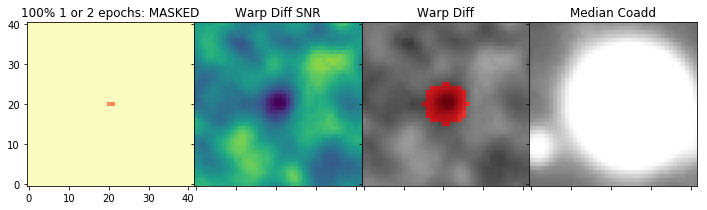

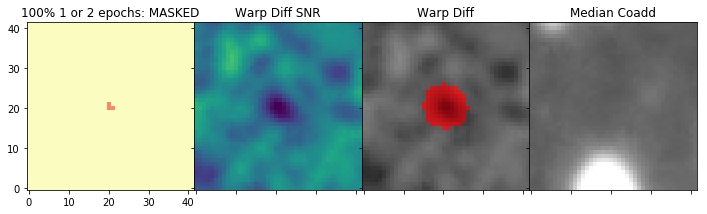

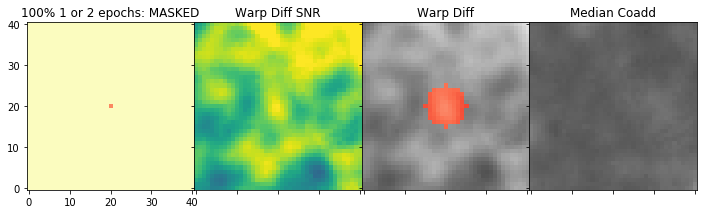

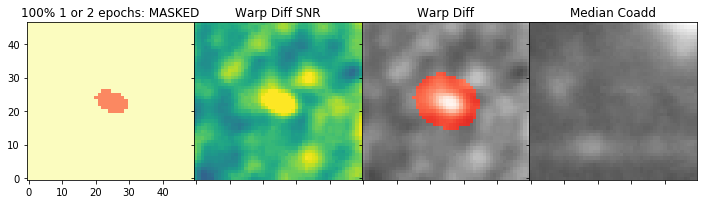

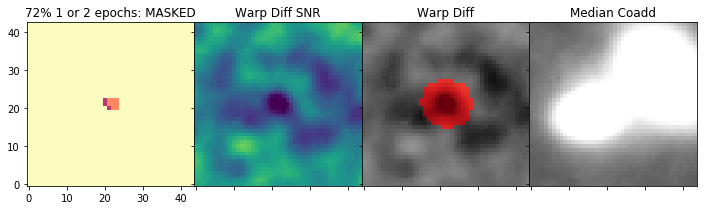

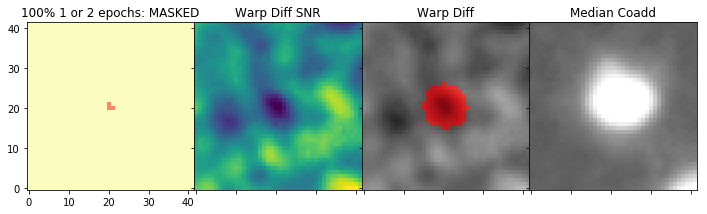

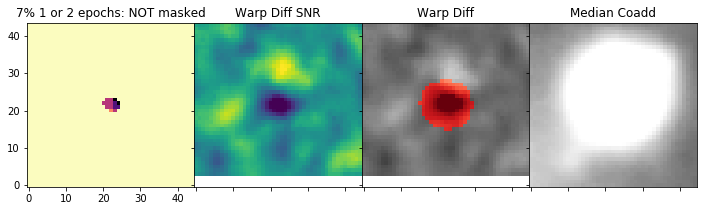

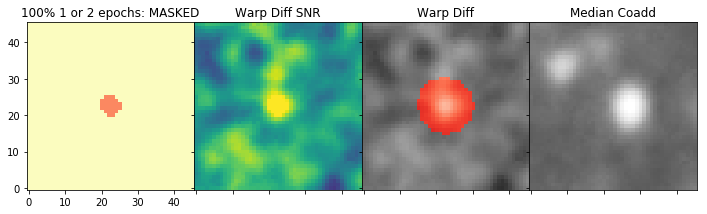

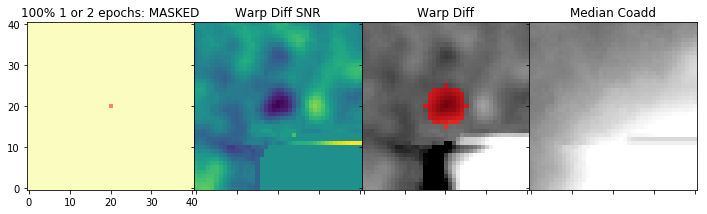

In [30]:
for i in random10:
    plotSpan(maskedSpans[i], im, snrIm,medianCoadd.maskedImage.image,  sum_count)
                               

Blink vs Median Coadd and Safe Clip:
```
ds9 -zscale robust-HSC-I-0-7,6-symmetric-1-2-dilate5-maskednans2.fits median-HSC-I-0-7,6.fits  &
ds9 -zscale robust-HSC-I-0-7,6-symmetric-1-2-dilate5-maskednans2.fits  safeClip-HSC-I-0-7,6.fits &
```

# Next steps

* Test
 * Visually what it does with the Y-band scattered light. 
 * Metrics?
 * What about variable stars. (Want them to be considered "subtraction junk")
* Stackify and merge (August sprint) 



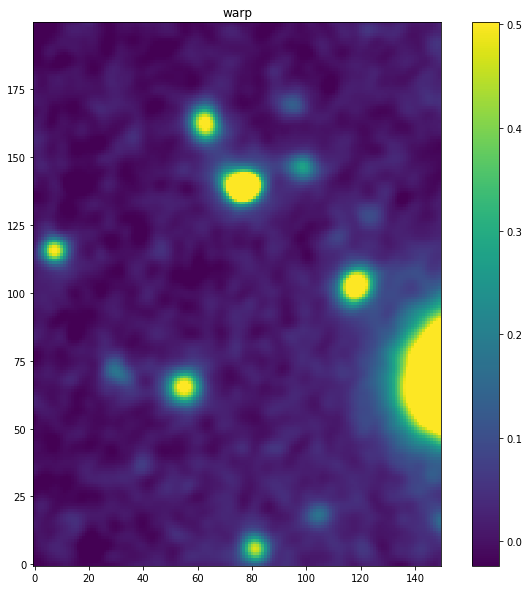

In [31]:
plot(medianCoadd.maskedImage.image.array[2300:2500, 450:600] + cube[keyList.index('1244')][2300:2500, 450:600], 'warp')

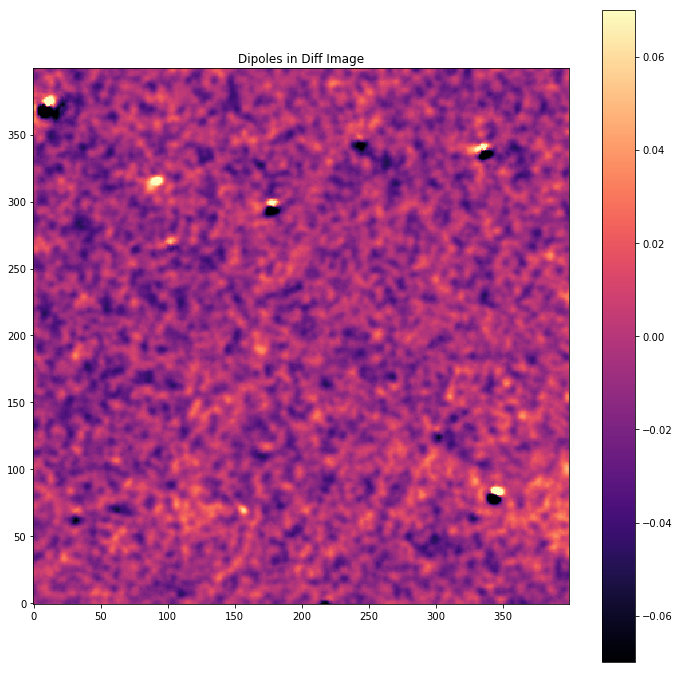

In [32]:
plt.figure(figsize=(12,12))
plt.imshow(cube[keyList.index('30504')][2000:2400, 600:1000],vmin=-0.07, vmax=0.07, origin='lower', cmap="magma", interpolation='nearest')
plt.title("Dipoles in Diff Image")
plt.colorbar()

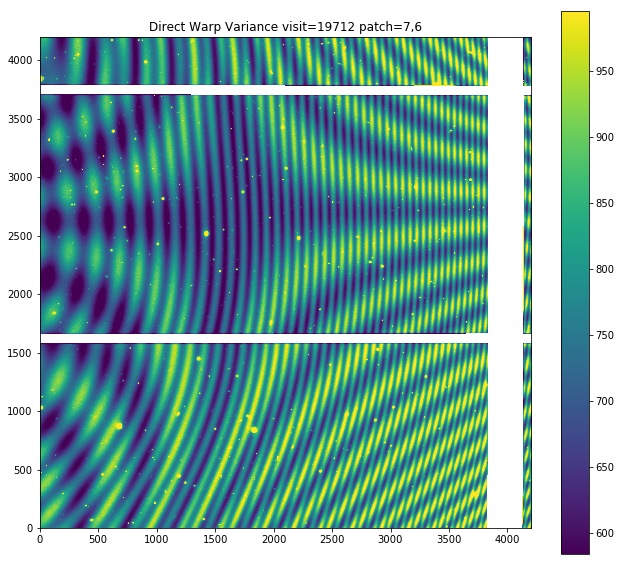

In [33]:
butlerCoadd = dafPersist.Butler('/tigress/HSC/HSC/rerun/alsayyad/cosmos_test_artifact_reject')
warp = butlerCoadd.get("deepCoadd_directWarp", patch='7,6', tract=0, filter='HSC-I', visit=19712)
plot(warp.getMaskedImage().getVariance().getArray(),
     'Direct Warp Variance visit=%s patch=7,6' % (19712),
     'viridis')

The following 33 image differences were generated as follows:

1.  __Generate median PSF-Matched coadd__ Matched to a DoubleGaussian w/ fwhm of 7 pixels. 
2.  __Diff = Warp - Median Coadd__
    
        Visit information:
        ALL: U-03-010001 HSC-I SSP_UDEEP_COSMOS
        1228	150.1104208	2.201652778	270	0.85364266	0.965629	3/28/14
        1230	150.1521292	2.160005556	270	0.86945261	0.959954	3/28/14
        1232	150.1938333	2.222472222	270	0.83653479	0.964513	3/28/14
        1238	150.127125	2.20995	270	0.76726676	1.0021	3/28/14
        1240	150.1688042	2.168322222	270	0.88539269	1.00218	3/28/14
        1242	150.2105042	2.230811111	270	0.83828394	0.99828	3/28/14
        1244	150.0854208	2.251622222	270	0.79821742	0.989406	3/28/14
        1246	150.0437083	2.189136111	270	0.78169936	1.00735	3/28/14
        1248	150.0687375	2.243311111	270	0.83069584	0.997942	3/28/14
        19658	150.1187542	2.20585	300	0.54768675	1.06164	1/21/15
        19660	150.1604542	2.164183333	300	0.60257457	1.06578	1/21/15
        19662	150.2021583	2.226661111	300	0.54025075	1.06682	1/21/15
        19680	150.0770625	2.247505556	300	0.5334654	1.06188	1/21/15
        19682	150.0353667	2.185013889	300	0.50978512	1.07004	1/21/15
        19684	150.2074208	2.176972222	300	0.53421238	1.06806	1/21/15
        19694	150.2491292	2.135283333	300	0.59834112	1.07035	1/21/15
        19696	150.290825	2.197811111	300	0.58604637	1.05552	1/21/15
        19698	150.1657458	2.218616667	300	0.70953974	1.02685	1/21/15
        19708	150.12405	2.156122222	300	1.11109388	0.936344	1/21/15
        19710	150.0715042	2.313080556	300	1.04386906	0.971211	1/21/15
        19712	150.1131875	2.271419444	300	0.97174324	0.990672	1/21/15
        30482	150.1549083	2.333888889	300	0.78258999	1.02168	5/21/15
        30484	150.0298	2.354744444	300	0.80335164	1.02104	5/21/15
        30486	149.9881167	2.292247222	300	0.73915699	1.04273	5/21/15
        30488	150.0081333	2.178627778	300	0.65142233	1.04633	5/21/15
        30490	150.0498208	2.13695	300	0.57450367	1.06437	5/21/15
        30492	150.0915083	2.199458333	300	0.66824797	1.04158	5/21/15
        30494	149.9664083	2.220294444	300	0.62858367	1.04537	5/21/15
        30496	149.9247375	2.157794444	300	0.63382774	1.03902	5/21/15
        30498	150.2232875	2.238361111	300	0.63693565	1.03903	5/21/15
        30500	150.2649875	2.196655556	300	0.57763524	1.05852	5/21/15
        30502	150.306675	2.259177778	300	0.55134729	1.04203	5/21/15
        30504	150.1815667	2.280036111	300	0.68257748	1.03591	5/21/15